In [1]:
import os
import mne
import numpy as np
from mne.decoding import CSP
import matplotlib.pyplot as plt

In [2]:
# Load data from two files
data_loo = mne.io.read_epochs_eeglab(input_fname = "D:\Mines_Ales\S9\Man_and_machine\AEP\Subject_13_H_AEP_Run_01.set")
data_tst = mne.io.read_epochs_eeglab(input_fname = "D:\Mines_Ales\S9\Man_and_machine\AEP\Subject_11_H_AEP_Run_01.set")

Extracting parameters from D:\Mines_Ales\S9\Man_and_machine\AEP\Subject_13_H_AEP_Run_01.set...
Not setting metadata
480 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from D:\Mines_Ales\S9\Man_and_machine\AEP\Subject_11_H_AEP_Run_01.set...
Not setting metadata
480 matching events found
No baseline correction applied
0 projection items activated
Ready.


In [3]:
# Detecte data from two file
x_loo = data_loo.get_data()
y_loo = data_loo.events[:,2]
x_tst = data_tst.get_data()
y_tst = data_tst.events[:,2]
n_components = 6
# Use csp to transform data
x_loo_csp_average = CSP(n_components=n_components, transform_into='average_power').fit_transform(x_loo, y_loo)
x_tst_csp_average = CSP(n_components=n_components, transform_into='average_power').fit_transform(x_tst, y_tst)


Computing rank from data with rank=None
    Using tolerance 1.5e-05 (2.2e-16 eps * 8 dim * 8.4e+09  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 6.1e-06 (2.2e-16 eps * 8 dim * 3.5e+09  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.7e-05 (2.2e-16 eps * 8 dim * 9.4e+09  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 6.9e-06 (2.2e-16 eps * 8 dim * 3.9e+09  max singular value)
    Estimated rank 

In [10]:
# Import classifiers and the Leave One Out methode
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import LeaveOneOut
from sklearn.tree import DecisionTreeClassifier
# Make a confusion matrix for each classifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

# Use linearDiscriminatAnalysis as the classifier
clf_LDA = LinearDiscriminantAnalysis()
clf_RFC = RandomForestClassifier(max_depth=2, random_state=0, max_features=6)
clf_DTC = DecisionTreeClassifier(random_state=0, max_features=6)

In [11]:
clf = ['LinearDiscriminantAnalysis','RandomForestClassifier', 'DecisionTreeClassifier']

Analysed with one leave out and result will be presented as a confusion matrix
------------------------------------------------------------------------------


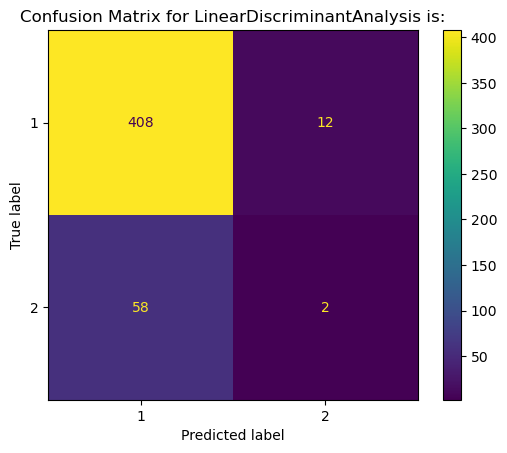

The confusion matrix (tn, fp, fn, tp) for classifier LinearDiscriminantAnalysis is: (408, 12, 58, 2)
The precision of model LinearDiscriminantAnalysis is: 14.29 %
The recall of model LinearDiscriminantAnalysis is: 3.33


C:\Users\ChenXiangru\AppData\Local\Temp\ipykernel_25104\2584735292.py:35: RuntimeWarning: invalid value encountered in longlong_scalars
  precision = round(tp/(tp+fp)*100,2)


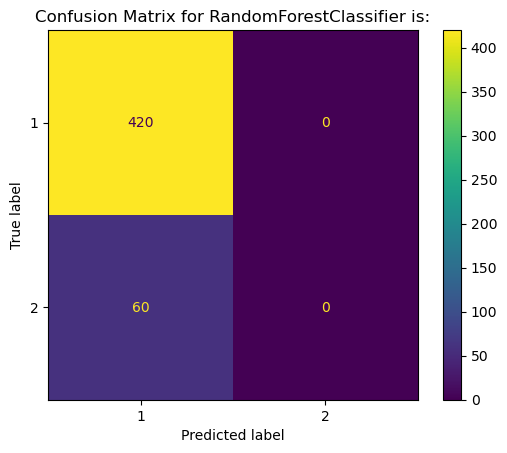

The confusion matrix (tn, fp, fn, tp) for classifier RandomForestClassifier is: (420, 0, 60, 0)
The precision of model RandomForestClassifier is: nan %
The recall of model RandomForestClassifier is: 0.0


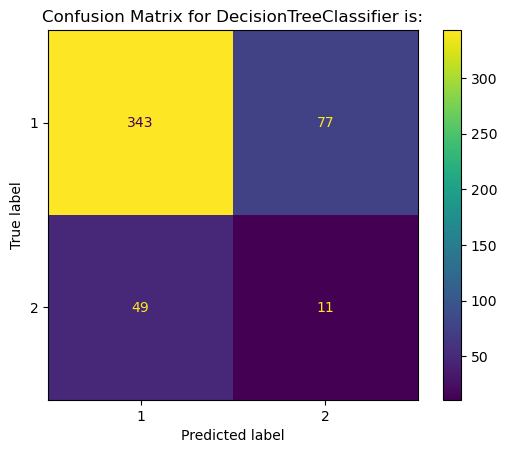

The confusion matrix (tn, fp, fn, tp) for classifier DecisionTreeClassifier is: (343, 77, 49, 11)
The precision of model DecisionTreeClassifier is: 12.5 %
The recall of model DecisionTreeClassifier is: 18.33
Test with the second file to get the best model identified on the first file
----------------------------------------------------------------------------
The score for the LinearDiscriminantAnalysis is: 84.58 %
The score for the RandomForestClassifier is: 87.5 %
The score for the DecisionTreeClassifier is: 71.04 %
The best classifier for the dataset is RandomForestClassifier


In [12]:
# This block first file will be analysed with leave one out and result will be in a confusion matrix
# Second file will be used as a test for the best model identified on the first file

print('Analysed with one leave out and result will be presented as a confusion matrix')
print('------------------------------------------------------------------------------')

# Use leave one out to split the dataset
loo = LeaveOneOut()
loo.get_n_splits(x_loo_csp_average)

# For each classifier make a dict for it
y_loo_pred = {}

for i in clf:
    y_loo_pred[i] = []

for train_index, test_index in loo.split(x_loo_csp_average):

    X_train, X_test = x_loo_csp_average[train_index], x_tst_csp_average[test_index]
    y_train, y_test = y_loo[train_index], y_loo[test_index]
    
    # Fit classifiers
    clf_LDA.fit(X_train, y_train)
    clf_RFC.fit(X_train, y_train)
    clf_DTC.fit(X_train, y_train)
    
    y_loo_pred['LinearDiscriminantAnalysis'].append(clf_LDA.predict(X_test)[0])
    y_loo_pred['RandomForestClassifier'].append(clf_RFC.predict(X_test)[0])
    y_loo_pred['DecisionTreeClassifier'].append(clf_DTC.predict(X_test)[0])

# Make a confusion matrix for each classifier
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
for i in clf:
    tn, fp, fn, tp = confusion_matrix(y_loo, y_loo_pred[i], labels=[1, 2]).ravel()
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
        
    ConfusionMatrixDisplay.from_predictions(y_loo, y_loo_pred[i])
    plt.title('Confusion Matrix for '+i+' is:')
    plt.show()
    
    print('The confusion matrix (tn, fp, fn, tp) for classifier '+i+' is:',(tn, fp, fn, tp))
    print('The precision of model '+i+' is:', precision)
    print('The recall of model '+i+' is:', recall)

print('Test with the second file to get the best model identified on the first file')
print('----------------------------------------------------------------------------')

print("The score for the LinearDiscriminantAnalysis is:", round(clf_LDA.score(x_tst_csp_average, y_tst)*100,2),'%')
print("The score for the RandomForestClassifier is:", round(clf_RFC.score(x_tst_csp_average, y_tst)*100,2),'%')
print("The score for the DecisionTreeClassifier is:", round(clf_DTC.score(x_tst_csp_average, y_tst)*100,2),'%')

score = [round(clf_LDA.score(x_tst_csp_average, y_tst)*100,2), round(clf_RFC.score(x_tst_csp_average, y_tst)*100,2), round(clf_DTC.score(x_tst_csp_average, y_tst)*100,2)]
index_clf = score.index(max(score))

print('The best classifier in which we choosed for this dataset is', clf[index_clf])

Computing rank from data with rank=None
    Using tolerance 1.5e-05 (2.2e-16 eps * 8 dim * 8.4e+09  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 6.1e-06 (2.2e-16 eps * 8 dim * 3.5e+09  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.7e-05 (2.2e-16 eps * 8 dim * 9.4e+09  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 6.9e-06 (2.2e-16 eps * 8 dim * 3.9e+09  max singular value)
    Estimated rank 

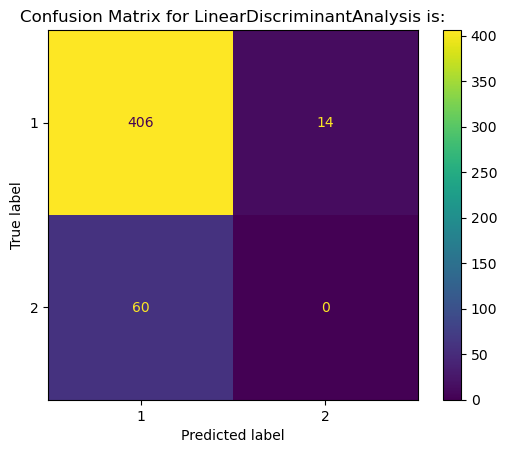

Confusion Matrix for LinearDiscriminantAnalysis is: tn( 406 ) fp( 14 ) fn( 60 ) tp( 0 )


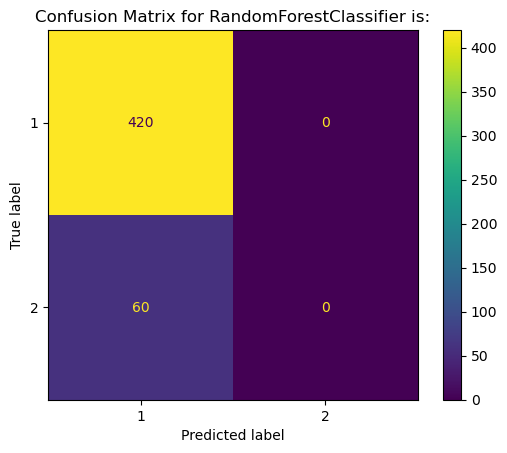

Confusion Matrix for RandomForestClassifier is: tn( 420 ) fp( 0 ) fn( 60 ) tp( 0 )


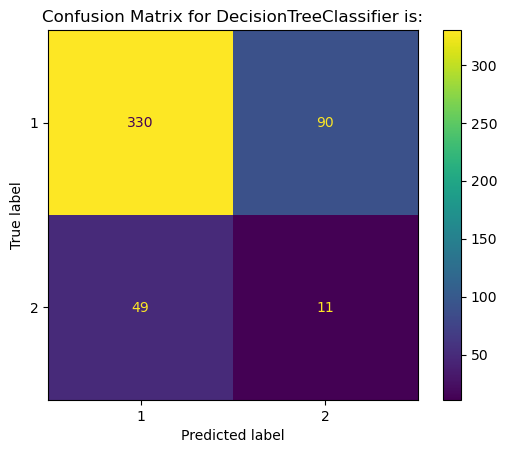

Confusion Matrix for DecisionTreeClassifier is: tn( 330 ) fp( 90 ) fn( 49 ) tp( 11 )


In [8]:
# This block the first file will be used to train the model with leave one out and the second file will be used to get confusion matrix

# First file will be analyzed in leave-one-out

#df=pd.DataFrame(x_loo_csp_average)


# Use leave one out to split the dataset
loo = LeaveOneOut()
loo.get_n_splits(x_loo_csp_average)

# For each classifier make a dict for it
y_tst_pred = {}


for i in clf:
    y_tst_pred[i] = []


# First file will be used in leave one out train
for train_index, test_index in loo.split(x_loo_csp_average):

    X_train, X_test = x_loo_csp_average[train_index], x_loo_csp_average[test_index]
    y_train, y_test = y_loo[train_index], y_tst[test_index]
    
    # Fit classifiers
    clf_LDA.fit(X_train, y_train)
    clf_RFC.fit(X_train, y_train)
    clf_DTC.fit(X_train, y_train)

# Seconde file will be used to calcul the 
y_tst_pred['LinearDiscriminantAnalysis'] = clf_LDA.predict(x_tst_csp_average)
y_tst_pred['RandomForestClassifier'] = clf_RFC.predict(x_tst_csp_average)
y_tst_pred['DecisionTreeClassifier'] = clf_DTC.predict(x_tst_csp_average)



for i in clf:
    ConfusionMatrixDisplay.from_predictions(y_tst, y_tst_pred[i])
    tn, fp, fn, tp = confusion_matrix(y_tst, y_tst_pred[i], labels=[1, 2]).ravel()
    
    plt.title('Confusion Matrix for '+i+' is:')
    plt.show()
    print('Confusion Matrix for '+i+' is: tn(',tn,') fp(',fp,') fn(',fn,') tp(',tp,')')

In [ ]:
# Other codes not concerne with projet

# Show the waveform of the dataset
events_num = data_loo.events
event_id = {'Frequence': 0, 'Target': 1}
data_loo.plot(butterfly=False, events=events_num, event_id=event_id)

# Filter dataset with band passe
data_loo.plot_psd(fmax=50)

# band-pass filtering in the range 1 Hz - 50 Hz
data_loo.filter(12., 30., fir_design='firwin')
data_loo.filter(1, 50., fir_design='firwin')

data_tst.plot_psd(fmax=50)